In [269]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [270]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [271]:
from colabgymrender.recorder import Recorder

In [272]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [273]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [274]:
# Xây dựng lại hàm reward để đánh giá hành động và trạng thái sau hành động 10

# nếu hành động là đi về phía bên trái và sau đó chiếc xe thật sự đi về phía bên trái
# (vận tốc âm) thì nhận được phần thưởng tương đương với vận tốc của chiếc xe lúc đó
# nhân với 10

# nếu sau khi thực hiện hành động, vị trí của chiếc xe >= 0.4, tức là gần chạm tới goal
# thì sẽ được thưởng 100 để khuyến khích hành động này

# đối với các hành động còn lại (không di chuyển hoặc di chuyển về phía bên phải) sẽ bị trừ
# 1 để chiếc xe đi đúng hướng và về đích nhanh nhất có thể

def my_reward(action, next_state):
    velocity = next_state[1]
    position = next_state[0]
    if action == 0 and velocity<0:
        return abs(velocity)*10
    elif position >= 0.4:
        return 100
    else:
        return -1

  and should_run_async(code)



In [275]:
total_reward

-200.0

In [276]:
# Hyperparameter

max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
# giảm gamma để tăng trọng số của giá trị reward ở thời điểm hiện tại
gamma = 0.95 # discount
# tăng learning rate
alpha = 0.0001 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [277]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], batch_size),
            nn.Tanh(),
            nn.Linear(batch_size, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [278]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [279]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        # sử dụng hàm reward tự định nghĩa
        reward = my_reward(action, next_state)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [280]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -153.36973242637322
Episode: 10 Step: 2000 Average reward: -151.77411562118942
Episode: 15 Step: 3000 Average reward: -146.75345149684233
Episode: 20 Step: 4000 Average reward: -143.23921033130566
Episode: 25 Step: 5000 Average reward: -139.5450937431271
Episode: 30 Step: 6000 Average reward: -135.583846403744
Episode: 35 Step: 7000 Average reward: -132.25739383644157
Episode: 40 Step: 8000 Average reward: -128.29347661250367
Episode: 45 Step: 9000 Average reward: -123.93182414733276
Episode: 50 Step: 10000 Average reward: -119.47288643249253
Episode: 55 Step: 11000 Average reward: -115.09057545205447
Episode: 60 Step: 12000 Average reward: -111.6045561824901
Episode: 65 Step: 13000 Average reward: -108.80003492333528
Episode: 70 Step: 14000 Average reward: -106.18363788440655
Episode: 75 Step: 15000 Average reward: -104.33625234576897
Episode: 80 Step: 16000 Average reward: -102.57378736183823
Episode: 85 Step: 17000 Average reward: -100.898278103

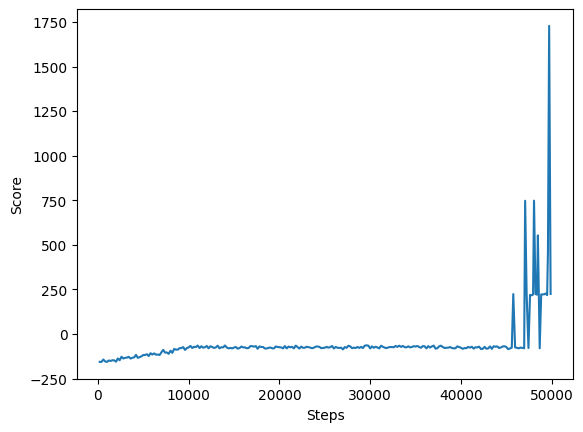

In [281]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [282]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-102.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  and should_run_async(code)

